In [169]:
import mailbox
import pandas as pd
import numpy as np
import datetime
import re
import csv
import pytz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from scipy.ndimage import gaussian_filter
import matplotlib.patches as mpatches
from scipy import interpolate
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

Defaulting to user installation because normal site-packages is not writeable


In [147]:
# set raw data mbox path
mboxfile = '~/Desktop/Important.mbox'

In [148]:
# read in mbox
mbox = mailbox.mbox(mboxfile)

Lets loop over the keys to see what Google keeps track of

In [149]:
for key in mbox[0].keys():
    print(key)

X-GM-THRID
X-Gmail-Labels
Delivered-To
Received
X-Google-Smtp-Source
X-Received
ARC-Seal
ARC-Message-Signature
ARC-Authentication-Results
Return-Path
Received
Received-SPF
Authentication-Results
DKIM-Signature
IronPort-SDR
X-IronPort-AV
Received
Received
IronPort-SDR
X-IronPort-AV
Received
Received
Received
From
To
Reply-to
Date
Subject
Message-ID
Content-Type
Content-Transfer-Encoding
MIME-Version
X-Mailer


Convert to csv

In [151]:
with open("mbox.csv", "w") as outfile:
    writer = csv.writer(outfile)
    for message in mbox:
        writer.writerow([message['subject'], message['from'], message['date'], message['to'],
                         message['X-Gmail-Labels'], message['X-GM-THRID']])

Read in the csv using read_csv and give the headers manually since mbox.csv doesn’t have any headers. We also convert the date to a datetime object.

In [152]:
df = pd.read_csv('mbox.csv', names=['subject', 'from', 'date', 'to', 'label', 'thread'])
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))
df = df[df['date'].notna()]

In [153]:
#Now lets print out some basic info

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20871 entries, 0 to 20883
Data columns (total 6 columns):
subject    20791 non-null object
from       20871 non-null object
date       20871 non-null datetime64[ns, UTC]
to         20767 non-null object
label      20871 non-null object
thread     20871 non-null int64
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 1.1+ MB


In [154]:
df.head()

,subject,from,date,to,label,thread
0,[SICE Help] Server Setup (ISSUE=68385 PROJ=53),SICE Help <sicehelp@indiana.edu>,2021-04-04 19:31:48+00:00,<liushaskymm@gmail.com>,"Inbox,Important,Opened,Category Personal",1696139609859864537
1,Digital Interview Request - New Link (If you h...,Sandi Landon <notifications-8521@app.bamboohr....,2021-04-01 17:34:33+00:00,Sky Liu <liushaskymm@gmail.com>,"Inbox,Important,Opened,Category Updates",1695860392939445317
2,Server Setup,Sam Chapman <samechap@iu.edu>,2021-04-04 19:30:55+00:00,"sicehelp@indiana.edu, ""Shei, Shing-Shong"" <she...","Inbox,Important,Opened,Category Personal",1696139487518285206
3,REI Order Confirmation #A214119839,=?UTF-8?B?UkVJIENvLW9w?= <rei@notices.rei.com>,2021-03-22 04:57:11+00:00,liushaskymm@gmail.com,"Inbox,Important,Category Promotions,Unread",1694906747259895449
4,Fwd: [SICE Help] Server Setup (ISSUE=68385 PRO...,Sam Chapman <samechap@iu.edu>,2021-04-05 13:33:05+00:00,Sky Liu <liushaskymm@gmail.com>,"Inbox,Important,Opened,Category Personal",1696207573953734434


In [155]:
def get_email_address(string):
    email = re.findall(r'<(.+?)>', string)
    if not email:
        email = list(filter(lambda y: '@' in y, string.split()))
    return email[0] if email else np.NAN

In [156]:
# apply to from column
df['from'] = df['from'].apply(lambda x: get_email_address(x))

# if email is from me, then it is sent, otherwiese it is in Inbox
me = 'liushaskymm@gmail.com'
df['label'] = df['from'].apply(lambda x: 'sent' if x==me else 'inbox')

# drop "to" column
df.drop(columns='to', inplace=True)

In [157]:
df.head()

,subject,from,date,label,thread
0,[SICE Help] Server Setup (ISSUE=68385 PROJ=53),sicehelp@indiana.edu,2021-04-04 19:31:48+00:00,inbox,1696139609859864537
1,Digital Interview Request - New Link (If you h...,notifications-8521@app.bamboohr.com,2021-04-01 17:34:33+00:00,inbox,1695860392939445317
2,Server Setup,samechap@iu.edu,2021-04-04 19:30:55+00:00,inbox,1696139487518285206
3,REI Order Confirmation #A214119839,rei@notices.rei.com,2021-03-22 04:57:11+00:00,inbox,1694906747259895449
4,Fwd: [SICE Help] Server Setup (ISSUE=68385 PRO...,samechap@iu.edu,2021-04-05 13:33:05+00:00,inbox,1696207573953734434


In [158]:
# convert to Eastern time zone
def convert_tz(x):

    # Indiana
#     mstart = datetime.datetime(2010, 8, 10, tzinfo=pytz.utc)
#     mstop = datetime.datetime(2018, 2, 12, tzinfo=pytz.utc)

    # Chicago
    pstart = datetime.datetime(2018, 2, 13, tzinfo=pytz.utc)
    pstop = datetime.datetime(2020, 1, 31, tzinfo=pytz.utc)

    if pstart < x < pstop:
        pst = pytz.timezone('US/Central')
        return x.astimezone(pst)

    else:
        est = pytz.timezone('US/Eastern')
        return x.astimezone(est)


df['date'] = df['date'].apply(lambda x: convert_tz(x))

# weekday name
df['dayofweek'] = df['date'].apply(lambda x: x.weekday_name)
df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
    'Saturday', 'Sunday'], ordered=True)

# time of day
df['timeofday'] = df['date'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

# hour
df['hour'] = df['date'].apply(lambda x: x.hour)

# year integer
df['year_int'] = df['date'].apply(lambda x: x.year)

# year fraction
df['year'] = df['date'].apply(lambda x: x.year + x.dayofyear/365.25)

# set date to index
df.index = df['date']
del df['date']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead


In [159]:
df.info

<bound method DataFrame.info of                                                                      subject  \
date                                                                           
2021-04-04 15:31:48-04:00     [SICE Help] Server Setup (ISSUE=68385 PROJ=53)   
2021-04-01 13:34:33-04:00  Digital Interview Request - New Link (If you h...   
2021-04-04 15:30:55-04:00                                       Server Setup   
2021-03-22 00:57:11-04:00                 REI Order Confirmation #A214119839   
2021-04-05 09:33:05-04:00  Fwd: [SICE Help] Server Setup (ISSUE=68385 PRO...   
...                                                                      ...   
2017-03-17 03:44:22-04:00         =?iso-8859-1?B?WW91J3JlIGFjdGl2YXRlZCE=?=    
2018-09-27 09:51:28-05:00                                        Fwd: Travel   
2020-08-10 17:02:17-04:00                                     Account Alerts   
2019-11-07 18:05:13-06:00                                         Gucci Time   
2020-07-

In [160]:
print(df.index.min().strftime('%a, %d %b %Y %I:%M %p'))
print(df.index.max().strftime('%a, %d %b %Y %I:%M %p'))
print('\n')
print(df['label'].value_counts())

Sat, 04 Jun 2011 01:05 AM
Mon, 05 Apr 2021 09:33 AM


inbox    20715
sent       156
Name: label, dtype: int64


Lets take a look at what time of day I send and receive emails over my Gmail history.

In [161]:
def plot_tod_vs_year(df, ax, color='C0', s=0.5, title='', add_indiana=False, add_chicago=False):

    ind = np.zeros(len(df), dtype='bool')
    est = pytz.timezone('US/Eastern')
    if add_indiana:
        start = datetime.datetime(2011, 8, 10, tzinfo=est)
        stop = datetime.datetime(2018, 2, 12, tzinfo=est)
        idx = np.logical_and(df.index>start, df.index<stop)
        ind += idx
        df[idx].plot.scatter('year', 'timeofday', s=s, alpha=0.6, ax=ax, color='C3')

    if add_chicago:
        start = datetime.datetime(2018, 2, 13, tzinfo=est)
        stop = datetime.datetime(2020, 1, 31, tzinfo=est)
        idx = np.logical_and(df.index>start, df.index<stop)
        ind += idx
        df[idx].plot.scatter('year', 'timeofday', s=s, alpha=0.6, ax=ax, color='C2')

    df[~ind].plot.scatter('year', 'timeofday', s=s, alpha=0.6, ax=ax, color=color)
    ax.set_ylim(0, 24)
    ax.yaxis.set_major_locator(MaxNLocator(8))
    ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                        for ts in ax.get_yticks()]);

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title)
    ax.grid(ls=':', color='k')

    return ax

In [162]:
sent.info

<bound method DataFrame.info of                                                                      subject  \
date                                                                           
2016-01-08 13:48:59-05:00   Hi siwei ...:Refinance at 2.89%. Dont Miss out.    
2013-11-10 21:20:58-05:00  Custom Transaction Detail (originally to: liu2...   

                                         from label               thread  \
date                                                                       
2016-01-08 13:48:59-05:00  liu226@indiana.edu  sent  1522824840372322463   
2013-11-10 21:20:58-05:00  liu226@indiana.edu  sent  1451372270721794130   

                          dayofweek  timeofday  hour  year_int         year  
date                                                                         
2016-01-08 13:48:59-05:00    Friday  13.816389    13      2016  2016.021903  
2013-11-10 21:20:58-05:00    Sunday  21.349444    21      2013  2013.859685  >

In [163]:
recvd.head()

,subject,from,label,thread,dayofweek,timeofday,hour,year_int,year
date,,,,,,,,,
2019-07-29 11:27:37-05:00,[External] Get a FREE trial-size FENTY BEAUTY ...,shop@beauty.sephora.com,inbox,1640410809116700017,Monday,11.460278,11,2019,2019.574949
2019-07-30 16:11:41-05:00,[External] Three perfect pieces that work for ...,jcrew@email.jcrew.com,inbox,1640519277830471467,Tuesday,16.194722,16,2019,2019.577687
2019-07-29 11:50:28-05:00,[External] Your Amazon.com order #111-9637217-...,shipment-tracking@amazon.com,inbox,1640412246929430344,Monday,11.841111,11,2019,2019.574949
2019-07-30 13:19:32-05:00,"[External] Select furniture: spend $100, save ...",targetnews@em.target.com,inbox,1640508447158659541,Tuesday,13.325556,13,2019,2019.577687
2019-07-29 07:18:36-05:00,[External] Christopher Pagdilao's invitation i...,messages-noreply@linkedin.com,inbox,1640395142166412548,Monday,7.310000,7,2019,2019.574949


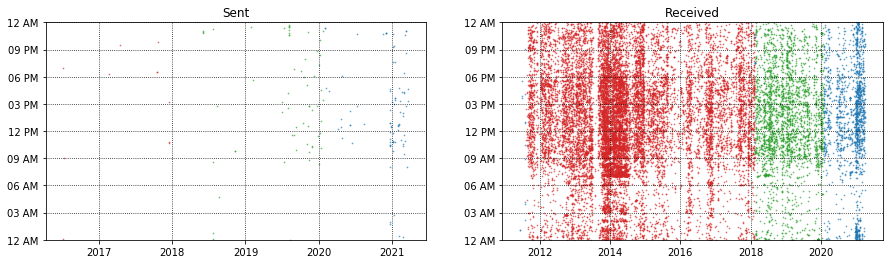

In [164]:
sent = df[df['label']=='sent']
recvd = df[df['label']=='inbox']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

plot_tod_vs_year(sent, ax[0], title='Sent', add_indiana=True, add_chicago=True)
plot_tod_vs_year(recvd, ax[1], title='Received', add_indiana=True, add_chicago=True);

In [165]:
def plot_count_vs_year(df, ax, label=None, dt=0.3, **plot_kwargs):
    """Plot average number of emails per day as a function of year."""

    year = df[df['year'].notna()]['year'].values
    T = year.max() - year.min()
    bins = int(T / dt)
    weights = 1 / (np.ones_like(year) * dt * 365.25)
    ax.hist(year, bins=bins, weights=weights, label=label, **plot_kwargs);
    ax.grid(ls=':', color='k')

In [166]:
def plot_count_vs_tod(df, ax, label=None, dt=1, smooth=False,
                      weight_fun=None, **plot_kwargs):
    """Plot average number of emails per hour as a function of time of day."""

    tod = df[df['timeofday'].notna()]['timeofday'].values
    year = df[df['year'].notna()]['year'].values
    Ty = year.max() - year.min()
    T = tod.max() - tod.min()
    bins = int(T / dt)
    if weight_fun is None:
        weights = 1 / (np.ones_like(tod) * Ty * 365.25 / dt)
    else:
        weights = weight_fun(df)
    if smooth:
        hst, xedges = np.histogram(tod, bins=bins, weights=weights);
        x = np.delete(xedges, -1) + 0.5*(xedges[1] - xedges[0])
        hst = gaussian_filter(hst, sigma=0.75)
        f = interpolate.interp1d(x, hst, kind='cubic')
        x = np.linspace(x.min(), x.max(), 10000)
        hst = f(x)
        ax.plot(x, hst, label=label, **plot_kwargs)
    else:
        ax.hist(tod, bins=bins, weights=weights, label=label, **plot_kwargs);


    ax.grid(ls=':', color='k')
    orientation = plot_kwargs.get('orientation')
    if orientation is None or orientation == 'vertical':
        ax.set_xlim(0, 24)
        ax.xaxis.set_major_locator(MaxNLocator(8))
        ax.set_xticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                            for ts in ax.get_xticks()]);
    elif orientation == 'horizontal':
        ax.set_ylim(0, 24)
        ax.yaxis.set_major_locator(MaxNLocator(8))
        ax.set_yticklabels([datetime.datetime.strptime(str(int(np.mod(ts, 24))), "%H").strftime("%I %p")
                            for ts in ax.get_yticks()])

In [167]:
class TriplePlot:
    """
    Plot a combination of emails as a function of time and year,
    average emails per day vs year and average number of
    emails per hour vs. time of day.
    """

    def __init__(self):

        gs = gridspec.GridSpec(6, 6)

        self.ax1 = plt.subplot(gs[2:6, :4])

        self.ax2 = plt.subplot(gs[2:6, 4:6], sharey=self.ax1)
        plt.setp(self.ax2.get_yticklabels(), visible=False);

        self.ax3 = plt.subplot(gs[:2, :4])
        plt.setp(self.ax3.get_xticklabels(), visible=False);

    def plot(self, df, color='darkblue', alpha=0.8, markersize=0.5, yr_bin=0.1, hr_bin=0.5):

        plot_tod_vs_year(df, self.ax1, color=color, s=markersize)
        plot_count_vs_tod(df, self.ax2, dt=hr_bin, color=color, alpha=alpha,
                          orientation='horizontal')
        self.ax2.set_xlabel('Average emails per hour')
        plot_count_vs_year(df, self.ax3, dt=yr_bin, color=color, alpha=alpha)
        self.ax3.set_ylabel('Average emails per day')

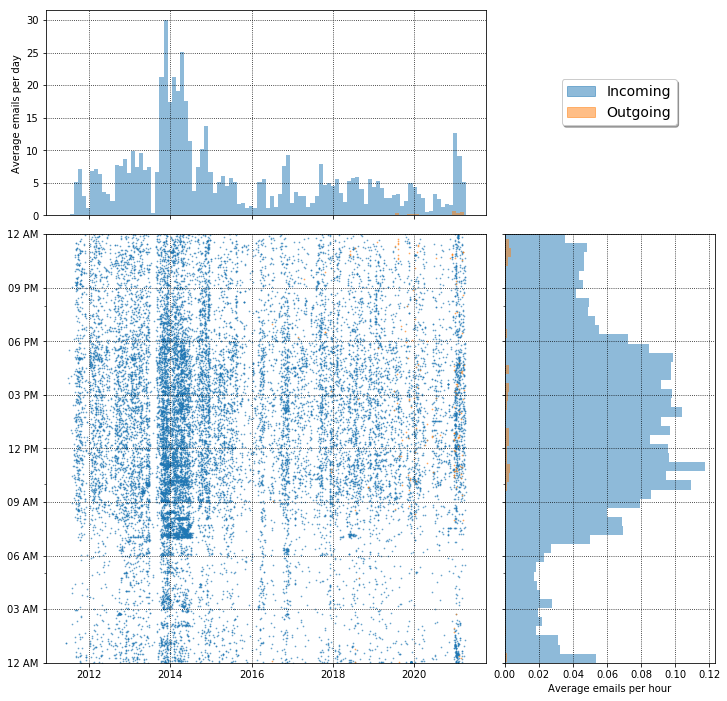

In [187]:
plt.figure(figsize=(12,12));
tpl = TriplePlot()

tpl.plot(recvd, color='C0', alpha=0.5)
tpl.plot(sent, color='C1', alpha=0.5)
p1 = mpatches.Patch(color='C0', label='Incoming', alpha=0.5)
p2 = mpatches.Patch(color='C1', label='Outgoing', alpha=0.5)
plt.legend(handles=[p1, p2], bbox_to_anchor=[1.45, 0.7], fontsize=14, shadow=True);

Who do I communicate with?
It is interesting to see who I communicate with the most. A simple way to do this is to just sort by the value counts of the email addresses. 

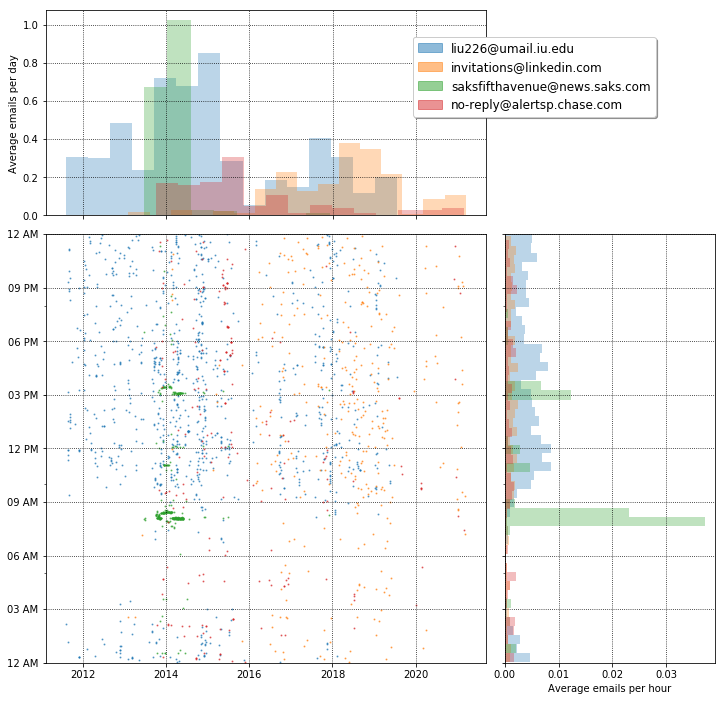

In [183]:
addrs = recvd['from'].value_counts()
plt.figure(figsize=(12,12));
tpl = TriplePlot()

labels = []
colors = ['C{}'.format(ii) for ii in range(9)]
idx = np.array([1,2,3,7])
for ct, addr in enumerate(addrs.index[idx]):
    tpl.plot(df[df['from'] == addr], color=colors[ct], alpha=0.3, yr_bin=0.5, markersize=1.0)
    labels.append(mpatches.Patch(color=colors[ct], label=addr, alpha=0.5))
plt.legend(handles=labels, bbox_to_anchor=[1.4, 0.9], fontsize=12, shadow=True);

What are my most active days?
So far we have looked at emails separated by time-of-day or by year but not by day. I could be interesting to see which days are my most active email days in terms of incoming and outgoing mail.

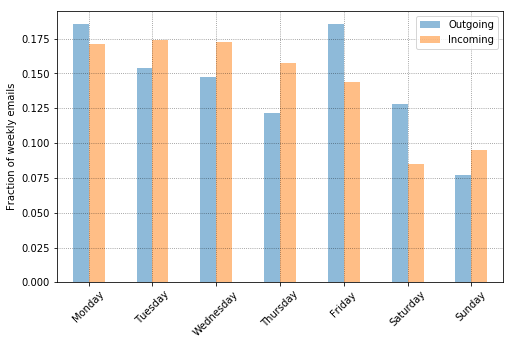

In [175]:
sdw = sent.groupby('dayofweek').size() / len(sent)
rdw = recvd.groupby('dayofweek').size() / len(recvd)

df_tmp = pd.DataFrame(data={'Outgoing': sdw, 'Incoming':rdw})
df_tmp.plot(kind='bar', rot=45, figsize=(8,5), alpha=0.5)
plt.xlabel('');
plt.ylabel('Fraction of weekly emails');
plt.grid(ls=':', color='k', alpha=0.5)

So lets take a look at email as a function of hour.

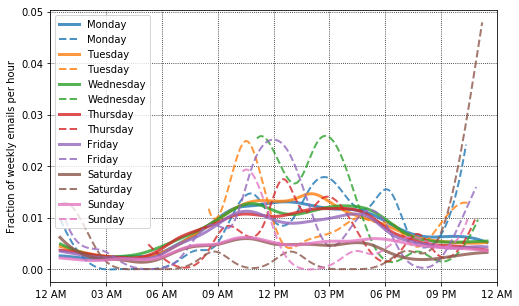

In [185]:
plt.figure(figsize=(8,5))
ax = plt.subplot(111)
for ct, dow in enumerate(df.dayofweek.cat.categories):
    df_r = recvd[recvd['dayofweek']==dow]
    weights = np.ones(len(df_r)) / len(recvd)
    wfun = lambda x: weights
    plot_count_vs_tod(df_r, ax, dt=1, smooth=True, color=f'C{ct}',
                      alpha=0.8, lw=3, label=dow, weight_fun=wfun)

    df_s = sent[sent['dayofweek']==dow]
    weights = np.ones(len(df_s)) / len(sent)
    wfun = lambda x: weights
    plot_count_vs_tod(df_s, ax, dt=1, smooth=True, color=f'C{ct}',
                      alpha=0.8, lw=2, label=dow, ls='--', weight_fun=wfun)
ax.set_ylabel('Fraction of weekly emails per hour')
plt.legend(loc='upper left');

What am I emailing about?

Lets remove the arxiv mailing list since that will contaminate our word clout with a bunch of email list boilerplate.

In [180]:
# remove arxiv emailers
df_no_arxiv = df[df['from'] != 'no-reply@arXiv.org']
text = ' '.join(map(str, sent['subject'].values))

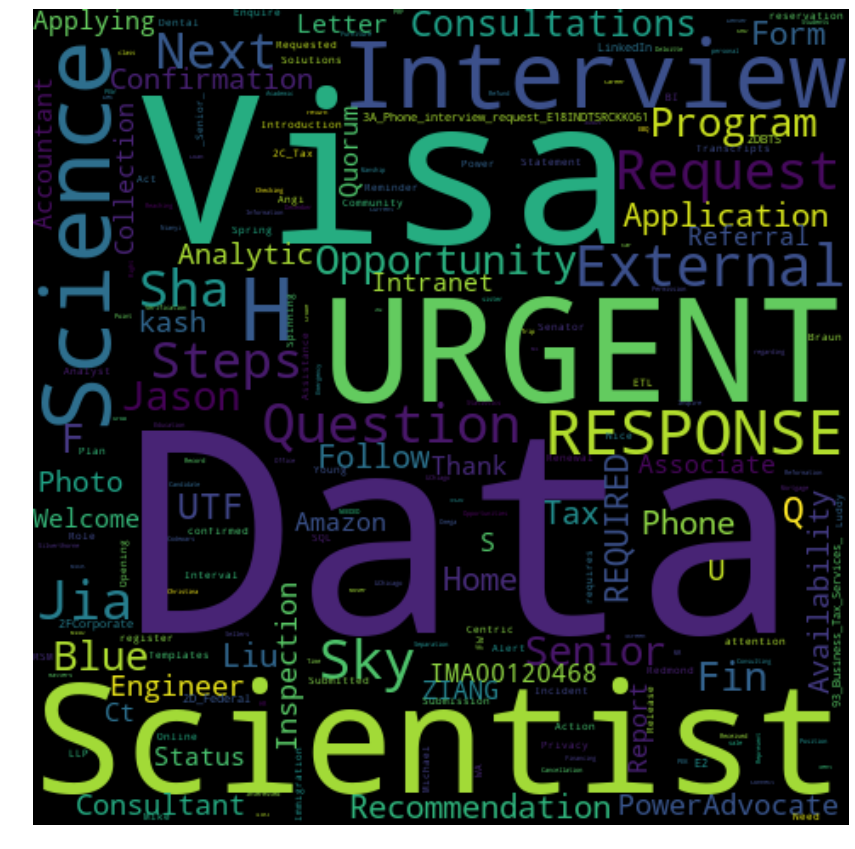

In [181]:
# Create the wordcloud object
stopwords = ['Re', 'Fwd']
wrd = WordCloud(width=480, height=480, margin=0, collocations=False)
for sw in stopwords:
    wrd.stopwords.add(sw)
wordcloud = wrd.generate(text)

# Display the generated image:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)